In [1]:
import pandas as pd
import numpy as np

# data 시각화
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline 
import seaborn as sns

# data split
from sklearn.model_selection import train_test_split
# Scale 변환
from sklearn.preprocessing import StandardScaler

# 평가 함수
from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import GridSearchCV

# 경고문 제거
import warnings
warnings.filterwarnings('ignore')

In [2]:
# 한글 폰트 설정
# !ls -l /usr/share/fonts/truetype/
!rm -rf ~/.cache/matplotlib/*
!fc-cache -fv

import matplotlib    
import matplotlib.font_manager

[f.name for f in matplotlib.font_manager.fontManager.ttflist if 'Nanum' in f.name]
# 유니코드 깨짐현상 해결
mpl.rcParams['axes.unicode_minus'] = False

# 나눔고딕 폰트 전체 적용
plt.rcParams["font.family"] = 'NanumMyeongjo'

/usr/share/fonts: caching, new cache contents: 0 fonts, 1 dirs
/usr/share/fonts/truetype: caching, new cache contents: 0 fonts, 2 dirs
/usr/share/fonts/truetype/humor-sans: caching, new cache contents: 1 fonts, 0 dirs
/usr/share/fonts/truetype/liberation: caching, new cache contents: 16 fonts, 0 dirs
/usr/local/share/fonts: caching, new cache contents: 0 fonts, 0 dirs
/root/.local/share/fonts: skipping, no such directory
/root/.fonts: skipping, no such directory
/usr/share/fonts/truetype: skipping, looped directory detected
/usr/share/fonts/truetype/humor-sans: skipping, looped directory detected
/usr/share/fonts/truetype/liberation: skipping, looped directory detected
/var/cache/fontconfig: cleaning cache directory
/root/.cache/fontconfig: not cleaning non-existent cache directory
/root/.fontconfig: not cleaning non-existent cache directory
fc-cache: succeeded


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# 데이터 수집

In [4]:
df_raw = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/SCALE불량.csv', encoding = 'euc-kr')
df_raw.head()

,PLATE_NO,ROLLING_DATE,SCALE,SPEC,STEEL_KIND,PT_THICK,PT_WIDTH,PT_LENGTH,PT_WEIGHT,FUR_NO,...,FUR_HZ_TEMP,FUR_HZ_TIME,FUR_SZ_TEMP,FUR_SZ_TIME,FUR_TIME,FUR_EXTEMP,ROLLING_TEMP_T5,HSB,ROLLING_DESCALING,WORK_GR
0,PB562774,2021-08-01:08:00:01,양품,AB/EH32-TM,T1,32.25,3707,15109,14180,1호기,...,1144,116,1133,59,282,1125,934,적용,8,2조
1,PB562775,2021-08-01:08:07:11,양품,AB/EH32-TM,T1,32.25,3707,15109,14180,1호기,...,1144,122,1135,53,283,1120,937,적용,8,2조
2,PB562776,2021-08-01:08:14:21,양품,NV-E36-TM,T8,33.27,3619,19181,18130,2호기,...,1129,116,1121,55,282,1106,889,적용,8,3조
3,PB562777,2021-08-01:08:21:31,양품,NV-E36-TM,T8,33.27,3619,19181,18130,2호기,...,1152,125,1127,68,316,1113,885,적용,8,3조
4,PB562778,2021-08-01:08:28:41,양품,BV-EH36-TM,T8,38.33,3098,13334,12430,3호기,...,1140,134,1128,48,314,1118,873,적용,8,1조


In [5]:
df_raw.describe().T

,count,mean,std,min,25%,50%,75%,max
PT_THICK,720.0,29.267857,19.152651,12.03,16.09,20.13,40.00,100.34
PT_WIDTH,720.0,2807.127778,517.839690,1800.00,2466.00,2725.00,3125.00,4575.00
PT_LENGTH,720.0,34323.269444,13828.434837,7893.00,22663.00,37380.00,43735.00,54917.00
PT_WEIGHT,720.0,41481.777778,24751.322015,7820.00,17757.50,36120.00,61120.00,115080.00
FUR_HZ_TEMP,720.0,1155.338889,20.866398,1103.00,1139.00,1158.00,1171.00,1206.00
FUR_HZ_TIME,720.0,88.204167,36.248696,43.00,65.00,75.00,101.00,251.00
FUR_SZ_TEMP,720.0,1149.666667,17.571788,1113.00,1132.00,1155.00,1164.00,1185.00
FUR_SZ_TIME,720.0,75.330556,26.086390,35.00,57.75,67.50,85.25,194.00
FUR_TIME,720.0,300.563889,45.390303,221.00,257.00,304.00,342.00,398.00
FUR_EXTEMP,720.0,1139.570833,17.857121,1102.00,1122.75,1144.00,1154.00,1175.00


압연온도 최소값이 0인 것은 이상치일 확률이 높다.

연속형 변수가 아닌 범주형 변수의 0,1은 object로 정의

In [6]:
df_raw['FUR_NO_ROW'] = df_raw['FUR_NO_ROW'].astype('object')
df_raw['WORK_GR'] = df_raw['WORK_GR'].astype('object')
df_raw['HSB'] = df_raw['HSB'].astype('object')
df_raw['SCALE'] = np.where(df_raw['SCALE'] == '양품', 0, 1) # 불량:1 양품:0으로 변환
df_raw['SCALE'] = df_raw['SCALE'].astype('object')

# 데이터 정제

## 결측치

## 이상치

### 압연온도 이상치 처리

In [7]:
from sklearn.impute import SimpleImputer

<AxesSubplot:>

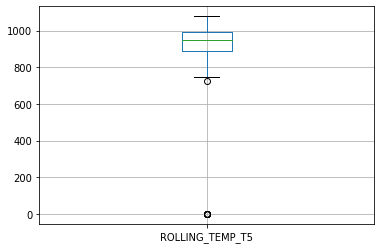

In [8]:
df_raw[['ROLLING_TEMP_T5']].boxplot()

In [9]:
df_raw.sort_values(by='ROLLING_TEMP_T5', ascending=False).tail(6)
df_raw.drop(df_raw[df_raw['ROLLING_TEMP_T5'] == 0].index, inplace=True)

<AxesSubplot:>

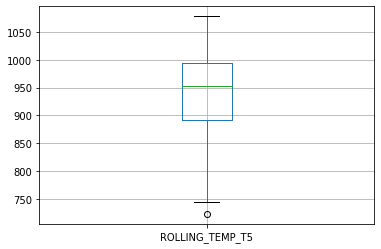

In [10]:
df_raw[['ROLLING_TEMP_T5']].boxplot()

<AxesSubplot:>

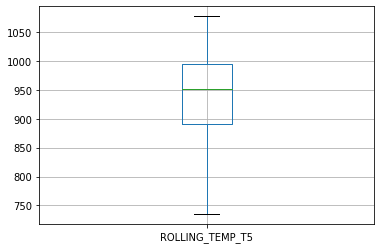

In [11]:
# FUR_HZ_TIME
IQR = df_raw['ROLLING_TEMP_T5'].quantile(0.75) - df_raw['ROLLING_TEMP_T5'].quantile(0.25)
line_down = df_raw['ROLLING_TEMP_T5'].quantile(0.25) - IQR*1.5
line_up = df_raw['ROLLING_TEMP_T5'].quantile(0.75) + IQR*1.5

winsoried = df_raw['ROLLING_TEMP_T5'].clip(line_down, line_up)
df_raw['ROLLING_TEMP_T5'] = winsoried 
df_raw[['ROLLING_TEMP_T5']].boxplot()

### 이상치 처리 : IQR 상한값 하한값 처리

In [12]:
# FUR_HZ_TIME
IQR = df_raw['FUR_HZ_TIME'].quantile(0.75) - df_raw['FUR_HZ_TIME'].quantile(0.25)
line_down = df_raw['FUR_HZ_TIME'].quantile(0.25) - IQR*1.5
line_up = df_raw['FUR_HZ_TIME'].quantile(0.75) + IQR*1.5

winsoried = df_raw['FUR_HZ_TIME'].clip(line_down, line_up)
df_raw['FUR_HZ_TIME'] = winsoried 
# FUR_SZ_TIME
IQR = df_raw['FUR_SZ_TIME'].quantile(0.75) - df_raw['FUR_SZ_TIME'].quantile(0.25)
line_down = df_raw['FUR_SZ_TIME'].quantile(0.25) - IQR*1.5
line_up = df_raw['FUR_SZ_TIME'].quantile(0.75) + IQR*1.5

winsoried = df_raw['FUR_SZ_TIME'].clip(line_down, line_up)
df_raw['FUR_SZ_TIME'] = winsoried 
# & PT_THICK
IQR = df_raw['PT_THICK'].quantile(0.75) - df_raw['PT_THICK'].quantile(0.25)
line_down = df_raw['PT_THICK'].quantile(0.25) - IQR*1.5
line_up = df_raw['PT_THICK'].quantile(0.75) + IQR*1.5

winsoried = df_raw['PT_THICK'].clip(line_down, line_up)
df_raw['PT_THICK'] = winsoried 
# PT_WIDTH 
IQR = df_raw['PT_WIDTH'].quantile(0.75) - df_raw['PT_WIDTH'].quantile(0.25)
line_down = df_raw['PT_WIDTH'].quantile(0.25) - IQR*1.5
line_up = df_raw['PT_WIDTH'].quantile(0.75) + IQR*1.5

winsoried = df_raw['PT_WIDTH'].clip(line_down, line_up)
df_raw['PT_WIDTH'] = winsoried 

<AxesSubplot:>

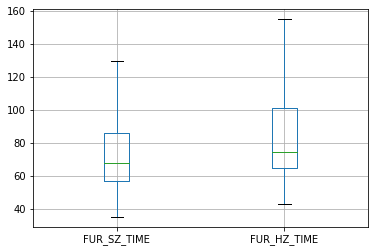

In [13]:
df_raw[['FUR_SZ_TIME', 'FUR_HZ_TIME']].boxplot()

<AxesSubplot:>

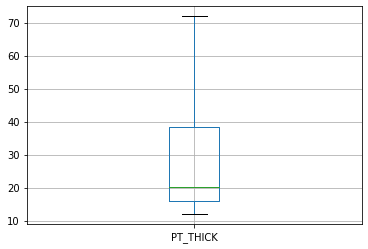

In [14]:
df_raw[['PT_THICK']].boxplot()

<AxesSubplot:>

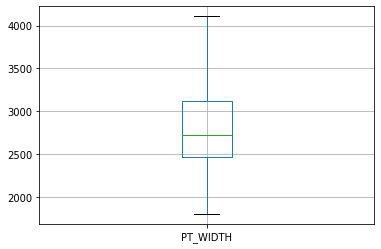

In [15]:
df_raw[['PT_WIDTH']].boxplot()

In [16]:
IQR = df_raw['ROLLING_TEMP_T5'].quantile(0.75) - df_raw['ROLLING_TEMP_T5'].quantile(0.25)
line_down = df_raw['ROLLING_TEMP_T5'].quantile(0.25) - IQR*1.5
line_up = df_raw['ROLLING_TEMP_T5'].quantile(0.75) + IQR*1.5

winsoried = df_raw['ROLLING_TEMP_T5'].clip(line_down, line_up)
df_raw['ROLLING_TEMP_T5'] = winsoried 

<AxesSubplot:>

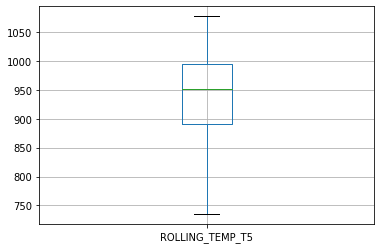

In [17]:
df_raw[['ROLLING_TEMP_T5']].boxplot()

# 탐색적 분석

## Histogam

불량품이 전체의 32%를 차지


In [18]:
def fun_plot_his(data, var):
    plt.figure(figsize = (3,3))
    plt.hist(data[data["SCALE"] == 0][var], label = "양품", alpha = 0.5)
    plt.hist(data[data["SCALE"] == 1][var], label = "불량", alpha = 0.5)
    plt.legend()

PT_THICK

1. 두께가 앏을 수록 scale이 증가한다.

Text(0.5, 0, 'PT_THICK')

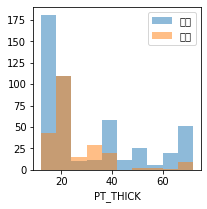

In [19]:
fun_plot_his(df_raw, 'PT_THICK')
plt.xlabel('PT_THICK')

Text(0.5, 0, 'PT_WIDTH')

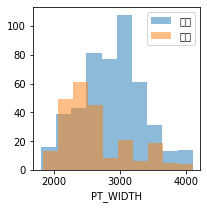

In [20]:
fun_plot_his(df_raw, 'PT_WIDTH')
plt.xlabel('PT_WIDTH')

2. 너비가 좁을 수록 scale이 증가한다.  

Text(0.5, 0, 'PT_LENGTH')

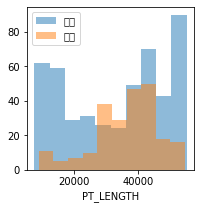

In [21]:
fun_plot_his(df_raw, 'PT_LENGTH')
plt.xlabel('PT_LENGTH')

3. 길이가 30000~40000까지는 scale의 비율 50%, 그 이상은 다시 양품의 비율이 증가한다.   

Text(0.5, 0, 'PT_WEIGHT')

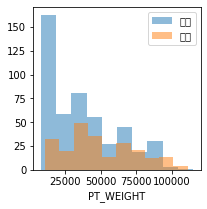

In [22]:
fun_plot_his(df_raw, 'PT_WEIGHT')
plt.xlabel('PT_WEIGHT')

Text(0.5, 0, 'FUR_HZ_TEMP')

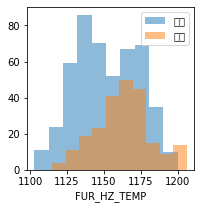

In [23]:
fun_plot_his(df_raw, 'FUR_HZ_TEMP')
plt.xlabel('FUR_HZ_TEMP')

4. 가열대 내부 온도가 1150 ~ 1175인 경우 scale의 비율이 증가하였다.  
- 온도의 구간별 설정(5등분) : / 1125 / 1150 / 1175 / 1200 /

Text(0.5, 0, 'FUR_SZ_TEMP')

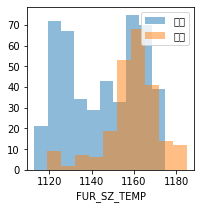

In [24]:
fun_plot_his(df_raw, 'FUR_SZ_TEMP')
plt.xlabel('FUR_SZ_TEMP')

Text(0.5, 0, 'FUR_HZ_TIME')

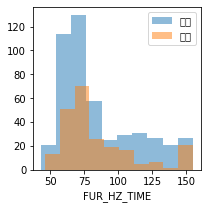

In [25]:
fun_plot_his(df_raw, 'FUR_HZ_TIME')
plt.xlabel('FUR_HZ_TIME')

6. 균열대 내부 온도가 1150도 이상인 경우 불량률이 증가한다.  

Text(0.5, 0, 'FUR_SZ_TIME')

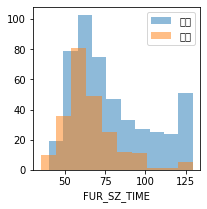

In [26]:
fun_plot_his(df_raw, 'FUR_SZ_TIME')
plt.xlabel('FUR_SZ_TIME')

Text(0.5, 0, 'FUR_EXTEMP')

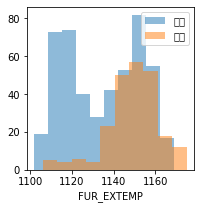

In [27]:
fun_plot_his(df_raw, 'FUR_EXTEMP')
plt.xlabel('FUR_EXTEMP')

9. 가열로 추출온도가 1140 이상에서 대부분의 scale이 분포하고 있다.   

Text(0.5, 0, 'ROLLING_TEMP_T5')

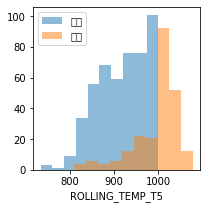

In [28]:
fun_plot_his(df_raw, 'ROLLING_TEMP_T5')
plt.xlabel('ROLLING_TEMP_T5')

강종별 불량률 비교

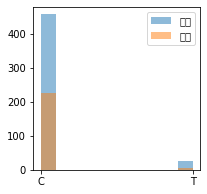

In [29]:
df_kind = df_raw.sort_values(['STEEL_KIND'], ascending = False)
df_T = df_kind.iloc[180:209,0:-1]
df_C1 = df_kind.iloc[0:180,0:-1]
df_C2 = df_kind.iloc[209:-1,0:-1]
df_C = pd.concat([df_C1, df_C2], ignore_index = True)
df_C['STEEL_KIND'] = 'C'
df_T['STEEL_KIND'] = 'T'
df_raw = pd.concat([df_C, df_T], ignore_index = True)
fun_plot_his(df_raw, 'STEEL_KIND')

탄소강에서 scale의 불량률이 높게 분석되었다.

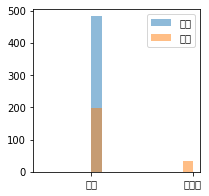

In [30]:
fun_plot_his(df_raw, 'HSB')

HSB를 처리하지 않은 경우, scale 불량이 100%이다.

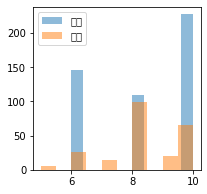

In [31]:
fun_plot_his(df_raw, 'ROLLING_DESCALING')

Descaling 횟수가 증가하더라도 scale 불량이 개선되지는 않는다.

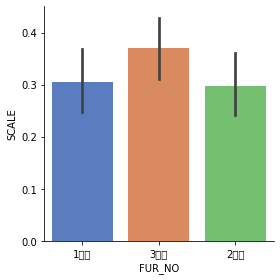

In [32]:
sns.catplot(x='FUR_NO', y='SCALE', data = df_raw, kind='bar', height = 4, palette = 'muted')

가열로 호기 마다의 scale 차이는 유의미하지 않다.

In [33]:
df_raw.columns

Index(['PLATE_NO', 'ROLLING_DATE', 'SCALE', 'SPEC', 'STEEL_KIND', 'PT_THICK',
       'PT_WIDTH', 'PT_LENGTH', 'PT_WEIGHT', 'FUR_NO', 'FUR_NO_ROW',
       'FUR_HZ_TEMP', 'FUR_HZ_TIME', 'FUR_SZ_TEMP', 'FUR_SZ_TIME', 'FUR_TIME',
       'FUR_EXTEMP', 'ROLLING_TEMP_T5', 'HSB', 'ROLLING_DESCALING'],
      dtype='object')

In [34]:
df_plot = pd.DataFrame()
df_plot['SCALE'] = df_raw['SCALE']
df_plot['GAP_TEMP'] = df_raw['FUR_EXTEMP'] - df_raw['ROLLING_TEMP_T5']

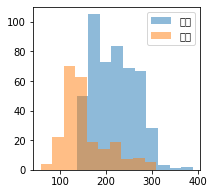

In [35]:
fun_plot_his(df_plot, 'GAP_TEMP')

추출온도와 압연온도의 차이가 클수록 불량률이 감소한다.

In [36]:
df_plot['RATE_HZ'] = df_raw['FUR_HZ_TEMP'] / df_raw['FUR_HZ_TIME']
df_plot['RATE_SZ'] = df_raw['FUR_SZ_TEMP'] / df_raw['FUR_SZ_TIME']

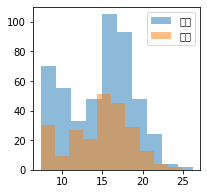

In [37]:
fun_plot_his(df_plot, 'RATE_HZ')

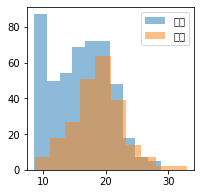

In [38]:
fun_plot_his(df_plot, 'RATE_SZ')

그래프 분석으로는 연관성을 확인할 수 없어 가설검정을 통해 확인할 예정

## SPEC : 불량률 비교(각 SPEC별로 어떤 온도에서 불량이 많이 발생하는가?)

# 가설검정

## t-test

### 가열로 가열속도와 불량률 관계

In [39]:
#통계 분석 
import statsmodels.api as sm
import scipy
from scipy import stats
from statsmodels.stats.proportion import proportions_ztest

In [40]:
df_t_test = pd.DataFrame()

In [41]:
# 가열로 추론 검정
mean_HZ = 14.67
df_t_test["SCALE"] = df_raw['SCALE']
df_t_test['RATE_HZ'] = df_plot['RATE_HZ']
df_raw['RATE_HZ'] = df_plot['RATE_HZ']
df_t_test= df_t_test[df_t_test['SCALE'] == 1]

statistic , p = stats.shapiro(df_t_test['RATE_HZ'])
print("가열로 가열속도와 불량률의 관계성 검정 : statistic = {0}, p-value = {1}".format(statistic, p))

가열로 가열속도와 불량률의 관계성 검정 : statistic = 0.9713217616081238, p-value = 0.0001258776756003499


### 균열로 가열속도와 불량률 관계

In [42]:
# 균열로 추론 검정
mean_SZ = 16.79
df_t_test["SCALE"] = df_raw['SCALE']
df_t_test['RATE_SZ'] = df_plot['RATE_SZ']
df_raw['RATE_SZ'] = df_plot['RATE_SZ']
df_t_test = df_t_test[df_t_test['SCALE'] == 1]

statistic , p = stats.shapiro(df_t_test['RATE_SZ'])
print("균열로 가열속도와 불량률의 관계성 검정 : statistic = {0}, p-value = {1}".format(statistic, p))

균열로 가열속도와 불량률의 관계성 검정 : statistic = 0.9891846776008606, p-value = 0.0806870386004448


### 압연온도와 불량률 관계

In [43]:
# 얍연온도 추론 검정
mean = 8.325
df_t_test["SCALE"] = df_raw['SCALE']
df_t_test['ROLLING_DESCALING'] = df_raw['ROLLING_DESCALING']
statistic , p = stats.shapiro(df_t_test['ROLLING_DESCALING'])
print("압연온도와 불량률의 관계성 검정 : statistic = {0}, p-value = {1}".format(statistic, p))

압연온도와 불량률의 관계성 검정 : statistic = 0.8666073083877563, p-value = 2.5448271419835355e-13


### 추출온도와 불량률 관계

In [44]:
# 추출온도 추론 검정
mean = 1139.64
df_t_test["SCALE"] = df_raw['SCALE']
df_t_test['FUR_EXTEMP'] = df_raw['FUR_EXTEMP']
statistic , p = stats.shapiro(df_t_test['FUR_EXTEMP'])
print("추출온도와 불량률의 관계성 검정 : statistic = {0}, p-value = {1}".format(statistic, p))

추출온도와 불량률의 관계성 검정 : statistic = 0.9493412971496582, p-value = 3.194342639289971e-07


### 온도차이와 불량률 관계

In [45]:
# 추출온도차이 추론 검정
df_t_test['GAP_TEMP'] = df_raw['FUR_EXTEMP'] - df_raw['ROLLING_DESCALING']
mean = df_t_test['GAP_TEMP'].mean()

statistic , p = stats.shapiro(df_t_test['GAP_TEMP'])
print("추출온도와 압연온도의 온도차이와 불량률의 관계성 검정 : statistic = {0}, p-value = {1}".format(statistic, p))

추출온도와 압연온도의 온도차이와 불량률의 관계성 검정 : statistic = 0.9529586434364319, p-value = 7.645685400348157e-07


## 분산분석

### 제품 두께 구간별 불량률의 차이 검정

In [46]:
df_PT_THICK = pd.DataFrame()
df_t_test["SCALE"] = df_raw['SCALE']
df_t_test["PT_THICK"] = df_raw['PT_THICK']
df_PT_THICK_A = df_raw[df_raw['PT_THICK'] < 16]
df_PT_THICK_A = df_PT_THICK_A[["SCALE", 'PT_THICK']]

df_PT_THICK_B = df_raw[(df_raw['PT_THICK'] > 16) & (df_raw['PT_THICK'] < 20)]
df_PT_THICK_B = df_PT_THICK_B[["SCALE", 'PT_THICK']]

df_PT_THICK_C = df_raw[(df_raw['PT_THICK'] > 20) & (df_raw['PT_THICK'] < 40)]
df_PT_THICK_C = df_PT_THICK_C[["SCALE", 'PT_THICK']]

df_PT_THICK_D = df_raw[df_raw['PT_THICK'] > 40]
df_PT_THICK_D = df_PT_THICK_D[["SCALE", 'PT_THICK']]

# 정규성 검정
statistic, p = stats.shapiro(df_PT_THICK_A['SCALE'])
statistic, p = stats.shapiro(df_PT_THICK_B['SCALE'])
statistic, p = stats.shapiro(df_PT_THICK_C['SCALE'])
statistic, p = stats.shapiro(df_PT_THICK_D['SCALE'])
print("구간 A 정규성 : statistic = {0}, p-value = {1}".format(statistic, p))
print("구간 B 정규성 : statistic = {0}, p-value = {1}".format(statistic, p))
print("구간 C 정규성 : statistic = {0}, p-value = {1}".format(statistic, p))
print("구간 D 정규성 : statistic = {0}, p-value = {1}".format(statistic, p), end='\n \n')
# 등분산성 검정
var_test = stats.levene(df_PT_THICK_A['SCALE'], df_PT_THICK_B['SCALE'], df_PT_THICK_C['SCALE'])
print(var_test,end='\n \n')
# ANOVA
f_result = stats.f_oneway(df_PT_THICK_A['SCALE'], df_PT_THICK_B['SCALE'], df_PT_THICK_C['SCALE'])

f, p = f_result.statistic.round(3), f_result.pvalue
print("One-Way")
print("F 통계량: {}".format(f))
print("p-value: {}".format(p))

구간 A 정규성 : statistic = 0.45924752950668335, p-value = 1.1726674840309805e-22
구간 B 정규성 : statistic = 0.45924752950668335, p-value = 1.1726674840309805e-22
구간 C 정규성 : statistic = 0.45924752950668335, p-value = 1.1726674840309805e-22
구간 D 정규성 : statistic = 0.45924752950668335, p-value = 1.1726674840309805e-22
 
LeveneResult(statistic=32.768508998960066, pvalue=3.809482096067452e-14)
 
One-Way
F 통계량: 36.567
p-value: 1.3235090665660158e-15


### 제품 너비 구간별 불량률의 차이 검정

In [47]:
df_PT_THICK = pd.DataFrame()
df_t_test["SCALE"] = df_raw['SCALE']
df_t_test["PT_WIDTH"] = df_raw['PT_WIDTH']
df_PT_THICK_A = df_raw[df_raw['PT_WIDTH'] < 2466]
df_PT_THICK_A = df_PT_THICK_A[["SCALE", 'PT_WIDTH']]

df_PT_THICK_B = df_raw[(df_raw['PT_WIDTH'] > 2466) & (df_raw['PT_WIDTH'] < 2725)]
df_PT_THICK_B = df_PT_THICK_B[["SCALE", 'PT_WIDTH']]

df_PT_THICK_C = df_raw[(df_raw['PT_WIDTH'] > 2725) & (df_raw['PT_WIDTH'] < 3125)]
df_PT_THICK_C = df_PT_THICK_C[["SCALE", 'PT_WIDTH']]

df_PT_THICK_D = df_raw[df_raw['PT_WIDTH'] > 3125]
df_PT_THICK_D = df_PT_THICK_D[["SCALE", 'PT_WIDTH']]

# 정규성 검정
statistic, p = stats.shapiro(df_PT_THICK_A['SCALE'])
statistic, p = stats.shapiro(df_PT_THICK_B['SCALE'])
statistic, p = stats.shapiro(df_PT_THICK_C['SCALE'])
statistic, p = stats.shapiro(df_PT_THICK_D['SCALE'])
print("구간 A 정규성 : statistic = {0}, p-value = {1}".format(statistic, p))
print("구간 B 정규성 : statistic = {0}, p-value = {1}".format(statistic, p))
print("구간 C 정규성 : statistic = {0}, p-value = {1}".format(statistic, p))
print("구간 D 정규성 : statistic = {0}, p-value = {1}".format(statistic, p), end='\n \n')
# 등분산성 검정
var_test = stats.levene(df_PT_THICK_A['SCALE'], df_PT_THICK_B['SCALE'], df_PT_THICK_C['SCALE'])
print(var_test,end='\n \n')
# ANOVA
f_result = stats.f_oneway(df_PT_THICK_A['SCALE'], df_PT_THICK_B['SCALE'], df_PT_THICK_C['SCALE'])

f, p = f_result.statistic.round(3), f_result.pvalue
print("One-Way")
print("F 통계량: {}".format(f))
print("p-value: {}".format(p))

구간 A 정규성 : statistic = 0.5189968943595886, p-value = 1.0412467155873684e-21
구간 B 정규성 : statistic = 0.5189968943595886, p-value = 1.0412467155873684e-21
구간 C 정규성 : statistic = 0.5189968943595886, p-value = 1.0412467155873684e-21
구간 D 정규성 : statistic = 0.5189968943595886, p-value = 1.0412467155873684e-21
 
LeveneResult(statistic=27.538943196847047, pvalue=4.3931428770905435e-12)
 
One-Way
F 통계량: 33.555
p-value: 2.0389864175625578e-14


# 모델링

In [48]:
# Data Split
random = 100
df_raw.drop(['ROLLING_DATE','PLATE_NO', 'SPEC','FUR_NO','FUR_NO_ROW'], axis = 1, inplace = True)
df_train, df_test = train_test_split(df_raw, test_size = 0.4, random_state = random)
df_raw['HSB'] = np.where(df_raw['HSB'] == '적용', 1, 0) # 적용:1 미적용:0으로 변환
df_raw['STEEL_KIND'] = np.where(df_raw['STEEL_KIND'] == 'C', 0, 1) # T:1 C:0으로 변환
print("train data size : {0}".format(df_train.shape))
print("test data size : {0}".format(df_test.shape))

train data size : (427, 17)
test data size : (286, 17)


## DT

In [49]:
# Decision Tree
from sklearn.tree import DecisionTreeClassifier

###  더미변수

In [50]:
df_raw["SCALE"] = pd.to_numeric(df_raw["SCALE"], errors = 'coerce')
df_raw = df_raw.astype({'PT_THICK' : 'int'})
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 713 entries, 0 to 712
Data columns (total 17 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   SCALE              713 non-null    int64  
 1   STEEL_KIND         713 non-null    int64  
 2   PT_THICK           713 non-null    int64  
 3   PT_WIDTH           713 non-null    float64
 4   PT_LENGTH          713 non-null    int64  
 5   PT_WEIGHT          713 non-null    int64  
 6   FUR_HZ_TEMP        713 non-null    int64  
 7   FUR_HZ_TIME        713 non-null    float64
 8   FUR_SZ_TEMP        713 non-null    int64  
 9   FUR_SZ_TIME        713 non-null    float64
 10  FUR_TIME           713 non-null    int64  
 11  FUR_EXTEMP         713 non-null    int64  
 12  ROLLING_TEMP_T5    713 non-null    float64
 13  HSB                713 non-null    int64  
 14  ROLLING_DESCALING  713 non-null    int64  
 15  RATE_HZ            713 non-null    float64
 16  RATE_SZ            713 non

In [51]:
# Data Split
df_raw_x = df_raw.drop("SCALE", axis = 1, inplace = False)
df_raw_y = df_raw["SCALE"]
random = 100
df_train_x, df_test_x, df_train_y, df_test_y = train_test_split(df_raw_x, df_raw_y, test_size = 0.4, random_state = random)

In [ ]:
# GridSearchCV를 이용한 최적의 파라미터 찾기
# estimator = DecisionTreeClassifier(random_state=random)

# para_depth = 10
# para_split = [n_split * 2 for n_split in range(8,20)]
# para_leaf = 8

# param_grid = {"max_features" : ['max_features=1.0', 'sqrt', 'log2'], 
#               'max_depth' : [10], 'min_samples_split' : para_split, 'min_samples_leaf' : [8]}

# grid_dt = GridSearchCV(estimator, param_grid, scoring="r2", n_jobs=-1)
# grid_dt.fit(df_train_x, df_train_y)

# print("best estimator model: \n{}".format(grid_dt.best_estimator_))
# print("\nbest parameter: \n{}".format(grid_dt.best_params_))
# print("\nbest score: \n{}".format(grid_dt.best_score_.round(3)))

In [52]:
train_acc = []
test_acc = []

para_depth = [depth for depth in range(1,21)]

for v_max_depth in para_depth:
    tree_max_depth = DecisionTreeClassifier(random_state = random, max_depth = v_max_depth)
    tree_max_depth.fit(df_train_x, df_train_y)
    train_acc.append(tree_max_depth.score(df_train_x, df_train_y))
    test_acc.append(tree_max_depth.score(df_test_x, df_test_y))

# 결과 저장
df_acc_max_depth = pd.DataFrame()
df_acc_max_depth["MinSampleLeaf"] = para_depth
df_acc_max_depth["TrainScore"] = train_acc
df_acc_max_depth["TestScore"] = test_acc

df_acc_max_depth.round(3)

,MinSampleLeaf,TrainScore,TestScore
0,1,0.902,0.871
1,2,0.937,0.895
2,3,0.970,0.951
3,4,0.977,0.958
4,5,0.979,0.958
5,6,0.981,0.958
6,7,0.984,0.958
7,8,0.986,0.948
8,9,0.988,0.944
9,10,0.993,0.948


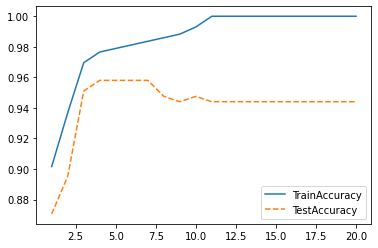

In [53]:
# 그래프
plt.plot(para_depth, train_acc, linestyle = "-", label = "TrainAccuracy")
plt.plot(para_depth, test_acc, linestyle = "--", label = "TestAccuracy")
plt.legend()

In [54]:
# max depth : 10
max_depth = 10
tree_max_depth = DecisionTreeClassifier(random_state = random, max_depth = max_depth)
tree_max_depth.fit(df_train_x, df_train_y)

print("Score_train : {0}".format(tree_max_depth.score(df_train_x, df_train_y)))
print("Score_test : {0}".format(tree_max_depth.score(df_test_x, df_test_y)))

Score_train : 0.9929742388758782
Score_test : 0.9475524475524476


In [55]:
# min sample leaf : 잎사귀 노드의 최소 자료 수 설정
train_score = []
test_score = []
para_leaf = [n_leaf * 1 for n_leaf in range(1,21)]

for v_min_samples_leaf in para_leaf:
    tree_min_sample_leaf = DecisionTreeClassifier(random_state = random, min_samples_leaf = v_min_samples_leaf)
    tree_min_sample_leaf.fit(df_train_x, df_train_y)
    train_score.append(tree_min_sample_leaf.score(df_train_x, df_train_y))
    test_score.append(tree_min_sample_leaf.score(df_test_x, df_test_y))

# 결과 저장
df_score_min_sample_leaf = pd.DataFrame()
df_score_min_sample_leaf["MinSampleLeaf"] = para_leaf
df_score_min_sample_leaf["TrainScore"] = train_score
df_score_min_sample_leaf["TestScore"] = test_score

# 설명력 확인
df_score_min_sample_leaf.round(3)

,MinSampleLeaf,TrainScore,TestScore
0,1,1.000,0.944
1,2,0.988,0.962
2,3,0.981,0.955
3,4,0.984,0.972
4,5,0.984,0.972
5,6,0.984,0.972
6,7,0.988,0.976
7,8,0.988,0.976
8,9,0.979,0.951
9,10,0.979,0.951


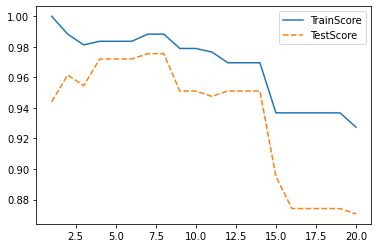

In [56]:
# 그래프
plt.plot(para_leaf, train_score, linestyle = "-", label = "TrainScore")
plt.plot(para_leaf, test_score, linestyle = "--", label = "TestScore")
plt.legend()

n_leaf = 8

In [57]:
tree_leaf = DecisionTreeClassifier(random_state = random, max_depth = max_depth, min_samples_leaf = n_leaf)
tree_leaf.fit(df_train_x, df_train_y)

print("Score_train : {0}".format(tree_max_depth.score(df_train_x, df_train_y)))
print("Score_test : {0}".format(tree_max_depth.score(df_test_x, df_test_y)))

Score_train : 0.9929742388758782
Score_test : 0.9475524475524476


In [58]:
train_acc = []
test_acc = []

para_split = [n_split * 2 for n_split in range(8,25)]

for v_para_split in para_split:
    tree_split = DecisionTreeClassifier(random_state = random, max_depth = max_depth, 
                                        min_samples_split = v_para_split, min_samples_leaf = n_leaf)
    tree_split.fit(df_train_x, df_train_y)
    train_acc.append(tree_split.score(df_train_x, df_train_y))
    test_acc.append(tree_split.score(df_test_x, df_test_y))

# 결과 저장
df_acc_split = pd.DataFrame()
df_acc_split["MinSplitLeaf"] = para_split
df_acc_split["TrainScore"] = train_acc
df_acc_split["TestScore"] = test_acc

df_acc_split.round(3)

,MinSplitLeaf,TrainScore,TestScore
0,16,0.988,0.976
1,18,0.988,0.976
2,20,0.988,0.976
3,22,0.988,0.976
4,24,0.988,0.976
5,26,0.988,0.976
6,28,0.988,0.976
7,30,0.988,0.976
8,32,0.988,0.976
9,34,0.988,0.976


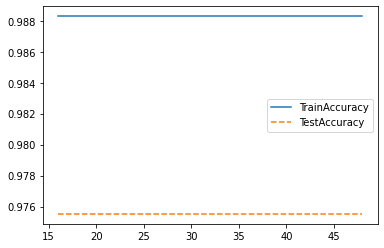

In [59]:
# 그래프
plt.plot(para_split, train_acc, linestyle = "-", label = "TrainAccuracy")
plt.plot(para_split, test_acc, linestyle = "--", label = "TestAccuracy")
plt.legend()

In [60]:
# Min_Sample_Split : 20
n_split = 20
tree_split = DecisionTreeClassifier(random_state = random, max_depth = max_depth, min_samples_split = n_split, min_samples_leaf = 8)
tree_split.fit(df_train_x, df_train_y)

print("Score_train : {0}".format(tree_split.score(df_train_x, df_train_y)))
print("Score_test : {0}".format(tree_split.score(df_test_x, df_test_y)))

Score_train : 0.9882903981264637
Score_test : 0.9755244755244755


In [61]:
tree_final = DecisionTreeClassifier(random_state = 100, min_samples_leaf = 8, min_samples_split = 20, max_depth = 10)
tree_final.fit(df_train_x, df_train_y)
y_pred = tree_final.predict(df_test_x)
print("Accuracy: {0:.3f}\n".format(tree_final.score(df_test_x,df_test_y)))
print("Confusion matrix: \n{0}".format(confusion_matrix(df_test_y, y_pred)))
print(classification_report(df_test_y, y_pred, digits=3))

Accuracy: 0.976

Confusion matrix: 
[[186   0]
 [  7  93]]
              precision    recall  f1-score   support

           0      0.964     1.000     0.982       186
           1      1.000     0.930     0.964       100

    accuracy                          0.976       286
   macro avg      0.982     0.965     0.973       286
weighted avg      0.976     0.976     0.975       286



### Feature Importance

Text(0, 0.5, '변수')

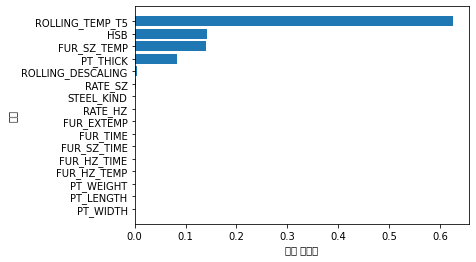

In [62]:
v_feature_name = df_train_x.columns
df_importance = pd.DataFrame()
df_importance["Feature"] = v_feature_name
df_importance["importance"] = tree_final.feature_importances_

# Importance 별로 정렬
df_importance.sort_values('importance', ascending = False, inplace = True)
df_importance.round(3)

# 그래프 도식화
df_importance.sort_values('importance', ascending = True, inplace = True)
coordinates = range(len(df_importance))
plt.barh(y = coordinates, width = df_importance['importance'])
plt.yticks(coordinates, df_importance['Feature'])
plt.xlabel("변수 중요도")
plt.ylabel("변수")

## RF

In [63]:
# Random Forest
from sklearn.ensemble import RandomForestClassifier

In [64]:
# GridSearchCV를 이용한 최적의 파라미터 찾기
estimator = RandomForestClassifier(random_state=random)

para_depth = [depth for depth in range(1,15)]
para_split = [n_split * 2 for n_split in range(8,20)]
para_leaf = [leaf for leaf in range(1,10)]
n_estimators = [estimators * 10 for estimators in range(1,20)]

param_grid = {"max_features" : ['max_features=1.0', 'sqrt', 'log2'], 
              'max_depth' : [10], 'min_samples_split' : para_split, 'min_samples_leaf' : [8], 'n_estimators' : n_estimators}

grid_dt = GridSearchCV(estimator, param_grid, scoring="r2", n_jobs=-1)
grid_dt.fit(df_train_x, df_train_y)

print("best estimator model: \n{}".format(grid_dt.best_estimator_))
print("\nbest parameter: \n{}".format(grid_dt.best_params_))
print("\nbest score: \n{}".format(grid_dt.best_score_.round(3)))

KeyboardInterrupt: ignored

In [65]:
train_acc = []
test_acc = []

n_estimators = [n_estimators * 10 for n_estimators in range(1,20)]

for v_n_tree in n_estimators:
    rf_n_tree = RandomForestClassifier(random_state = random, n_estimators = v_n_tree)
    rf_n_tree.fit(df_train_x, df_train_y)
    train_acc.append(rf_n_tree.score(df_train_x, df_train_y))
    test_acc.append(rf_n_tree.score(df_test_x, df_test_y))

# 결과 저장
rf_acc_n_tree = pd.DataFrame()
rf_acc_n_tree["MinSampleLeaf"] = n_estimators
rf_acc_n_tree["TrainScore"] = train_acc
rf_acc_n_tree["TestScore"] = test_acc

rf_acc_n_tree.round(3)

,MinSampleLeaf,TrainScore,TestScore
0,10,0.998,0.909
1,20,1.000,0.937
2,30,1.000,0.920
3,40,1.000,0.927
4,50,0.998,0.944
5,60,0.998,0.944
6,70,0.998,0.941
7,80,1.000,0.941
8,90,1.000,0.941
9,100,1.000,0.948


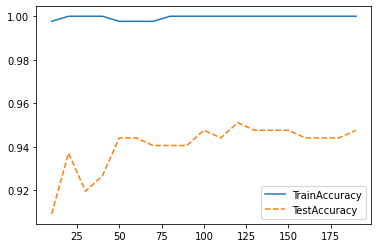

In [66]:
# 그래프
plt.plot(n_estimators, train_acc, linestyle = "-", label = "TrainAccuracy")
plt.plot(n_estimators, test_acc, linestyle = "--", label = "TestAccuracy")
plt.legend()

Text(0.5, 0, 'n_estimators')

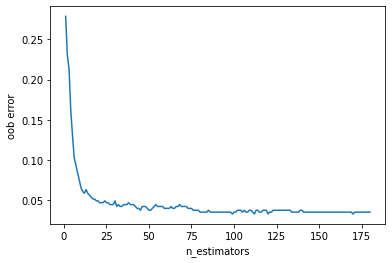

In [67]:
oob_error = []
for v_n_tree in range(1,181):
    rf = RandomForestClassifier(random_state = random, n_estimators = v_n_tree, oob_score = True)
    rf.fit(df_train_x, df_train_y)
    oob_error.append(1 - rf.oob_score_)
    
plt.plot(range(1,181), oob_error)
plt.ylabel("oob error")
plt.xlabel("n_estimators")

In [68]:
# Tree 수 지정
n_tree = 120
train_acc = []
test_acc = []

para_depth = [depth for depth in range(1,11)]

for v_max_depth in para_depth:
    rf_max_depth = RandomForestClassifier(random_state = random, max_depth = v_max_depth, n_estimators = n_tree)
    rf_max_depth.fit(df_train_x, df_train_y)
    train_acc.append(rf_max_depth.score(df_train_x, df_train_y))
    test_acc.append(rf_max_depth.score(df_test_x, df_test_y))

# 결과 저장
rf_acc_max_depth = pd.DataFrame()
rf_acc_max_depth["MinSampleLeaf"] = para_depth
rf_acc_max_depth["TrainScore"] = train_acc
rf_acc_max_depth["TestScore"] = test_acc

rf_acc_max_depth.round(3)

,MinSampleLeaf,TrainScore,TestScore
0,1,0.874,0.850
1,2,0.899,0.871
2,3,0.939,0.885
3,4,0.960,0.892
4,5,0.979,0.913
5,6,0.979,0.927
6,7,0.981,0.944
7,8,0.995,0.948
8,9,0.995,0.948
9,10,0.998,0.944


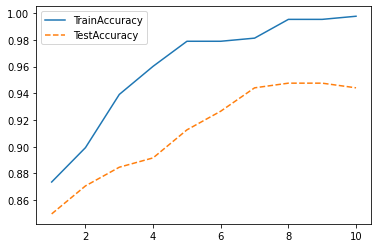

In [69]:
# 그래프
plt.plot(para_depth, train_acc, linestyle = "-", label = "TrainAccuracy")
plt.plot(para_depth, test_acc, linestyle = "--", label = "TestAccuracy")
plt.legend()

# Max_depth 설정
max_depth = 8

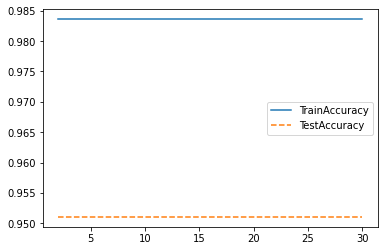

In [70]:
train_acc = []
test_acc = []

para_leaf = [n_leaf * 2 for n_leaf in range(1,16)]

for v_para_leaf in para_leaf:
    rf_leaf = RandomForestClassifier(random_state = random, max_depth = max_depth , min_samples_split = n_split)
    rf_leaf.fit(df_train_x, df_train_y)
    train_acc.append(rf_leaf.score(df_train_x, df_train_y))
    test_acc.append(rf_leaf.score(df_test_x, df_test_y))

# 결과 저장
rf_acc_leaf = pd.DataFrame()
rf_acc_leaf["MinSampleLeaf"] = para_leaf
rf_acc_leaf["TrainScore"] = train_acc
rf_acc_leaf["TestScore"] = test_acc

rf_acc_leaf.round(3)

# 그래프
plt.plot(para_leaf, train_acc, linestyle = "-", label = "TrainAccuracy")
plt.plot(para_leaf, test_acc, linestyle = "--", label = "TestAccuracy")
plt.legend()

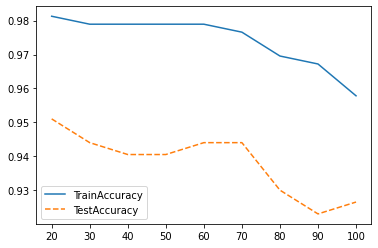

In [71]:
train_acc = []
test_acc = []

para_split = [n_split * 10 for n_split in range(2,11)]

for v_para_split in para_split:
    rf_split = RandomForestClassifier(n_estimators = n_tree, random_state = random, 
                                      max_depth = max_depth , min_samples_split = v_para_split)
    rf_split.fit(df_train_x, df_train_y)
    train_acc.append(rf_split.score(df_train_x, df_train_y))
    test_acc.append(rf_split.score(df_test_x, df_test_y))

# 결과 저장
rf_acc_split = pd.DataFrame()
rf_acc_split["MinSampleLeaf"] = para_split
rf_acc_split["TrainScore"] = train_acc
rf_acc_split["TestScore"] = test_acc

rf_acc_split.round(3)

# 그래프
plt.plot(para_split, train_acc, linestyle = "-", label = "TrainAccuracy")
plt.plot(para_split, test_acc, linestyle = "--", label = "TestAccuracy")
plt.legend()

n_split = 60

In [72]:
rf_final = RandomForestClassifier(random_state = 100, min_samples_leaf = 8, min_samples_split = 32, max_depth = 8, n_estimators = 120)
rf_final.fit(df_train_x, df_train_y)

RandomForestClassifier(max_depth=8, min_samples_leaf=8, min_samples_split=32,
                       n_estimators=120, random_state=100)

In [73]:
rf_final = RandomForestClassifier(random_state = 100, min_samples_leaf = 8, min_samples_split = 20, max_depth = 8, n_estimators = 120)
rf_final.fit(df_train_x, df_train_y)

print("Score_train : {0}".format(rf_final.score(df_train_x, df_train_y)))
print("Score_test : {0}".format(rf_final.score(df_test_x, df_test_y)))

Score_train : 0.9414519906323185
Score_test : 0.8846153846153846


In [149]:
# Model Predict
rf_finally = RandomForestClassifier(random_state = 100, min_samples_leaf = 20, min_samples_split = 60, max_depth = 5)
rf_finally.fit(df_train_x,df_train_y)
y_pred_rf = rf_finally.predict(df_test_x)
print("Accuracy: {0:.3f}\n".format(rf_finally.score(df_test_x,df_test_y)))
print("Confusion matrix: \n{0}".format(confusion_matrix(df_test_y, y_pred_rf)))
print(classification_report(df_test_y, y_pred_rf, digits=3))

Accuracy: 0.663

Confusion matrix: 
[[188   2]
 [ 95   3]]
              precision    recall  f1-score   support

           0      0.664     0.989     0.795       190
           1      0.600     0.031     0.058        98

    accuracy                          0.663       288
   macro avg      0.632     0.510     0.427       288
weighted avg      0.642     0.663     0.544       288



### Feature Importance

Text(0, 0.5, '변수')

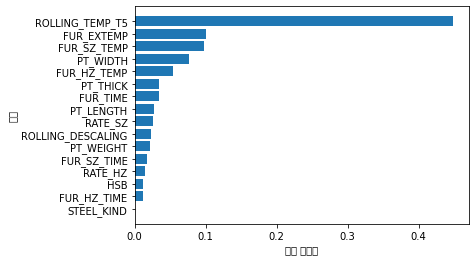

In [75]:
rf_importance = pd.DataFrame()
rf_importance["Feature"] = v_feature_name
rf_importance["importance"] = rf_final.feature_importances_

# Importance 별로 정렬
rf_importance.sort_values('importance', ascending = False, inplace = True)
rf_importance.round(3)

# 그래프 도식화
rf_importance.sort_values('importance', ascending = True, inplace = True)
coordinates = range(len(df_importance))
plt.barh(y = coordinates, width = rf_importance['importance'])
plt.yticks(coordinates, rf_importance['Feature'])
plt.xlabel("변수 중요도")
plt.ylabel("변수")

## GB

In [76]:
from sklearn.ensemble import GradientBoostingClassifier

In [77]:
# train, test 정확도 결과 저장용
train_accuracy = []; test_accuracy = []; differance = []

# 학습률 변경
para_lr = [lr *0.1 for lr in range(1,10)]

for v_learning_rate in para_lr:
    gb = GradientBoostingClassifier(learning_rate = v_learning_rate, random_state = random)
    gb.fit(df_train_x, df_train_y)
    train_accuracy.append(gb.score(df_train_x, df_train_y))
    test_accuracy.append(gb.score(df_test_x, df_test_y))
    differance.append((gb.score(df_train_x, df_train_y)) - (gb.score(df_test_x, df_test_y)))
    
#데이텉 테이블로 저장
df_accuracy_lr = pd.DataFrame()
df_accuracy_lr['LearningRate'] = para_lr
df_accuracy_lr['TrainAccuracy'] = train_accuracy
df_accuracy_lr['TestAccuracy'] = test_accuracy

df_accuracy_lr.round(3)

,LearningRate,TrainAccuracy,TestAccuracy
0,0.1,1.0,0.976
1,0.2,1.0,0.976
2,0.3,1.0,0.979
3,0.4,1.0,0.986
4,0.5,1.0,0.986
5,0.6,1.0,0.983
6,0.7,1.0,0.983
7,0.8,1.0,0.958
8,0.9,1.0,0.951


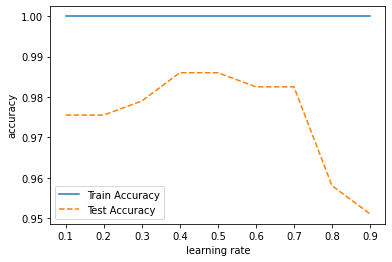

In [78]:
#모델로 정확도 확인
df_accuracy_lr.round(3)
plt.plot(para_lr, train_accuracy, linestyle = '-', label = 'Train Accuracy')
plt.plot(para_lr, test_accuracy, linestyle = '--', label = 'Test Accuracy')
plt.ylabel('accuracy') ; plt.xlabel('learning rate')
plt.legend()

In [79]:
train_accuracy = []; test_accuracy = []

para_n_tree = [n_tree*10 for n_tree in range(1,16)]

for v_n_estimators in para_n_tree:
    gb = GradientBoostingClassifier(n_estimators= v_n_estimators,learning_rate = 0.4, random_state = random)
    gb.fit(df_train_x, df_train_y)
    train_accuracy.append(gb.score(df_train_x, df_train_y))
    test_accuracy.append(gb.score(df_test_x, df_test_y))
    
# 데이터 테이블로 저장
df_accuracy_n = pd.DataFrame()
df_accuracy_n['Estimators'] = para_n_tree
df_accuracy_n['TrainAccuracy'] = train_accuracy
df_accuracy_n['TestAccuracy'] = test_accuracy

# 모델 정확도 확인
df_accuracy_n.head(10)

,Estimators,TrainAccuracy,TestAccuracy
0,10,0.990632,0.972028
1,20,1.000000,0.975524
2,30,1.000000,0.975524
3,40,1.000000,0.979021
4,50,1.000000,0.982517
5,60,1.000000,0.982517
6,70,1.000000,0.986014
7,80,1.000000,0.986014
8,90,1.000000,0.986014
9,100,1.000000,0.986014


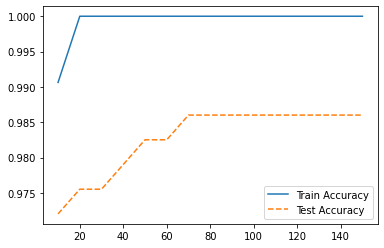

In [80]:
plt.plot(para_n_tree, train_accuracy, linestyle = '-', label = 'Train Accuracy')
plt.plot(para_n_tree, test_accuracy, linestyle = '--', label = 'Test Accuracy')
plt.legend()

In [81]:
# train, test 정확도 결과 저장용
train_accuracy = []; test_accuracy = []

# min_samples_split
para_depth = [depth for depth in range(1,11)]

for v_max_depth in para_depth:
    gb = GradientBoostingClassifier(max_depth = v_max_depth, learning_rate = 0.4, n_estimators = 70, random_state = random)
    gb.fit(df_train_x, df_train_y)
    train_accuracy.append(gb.score(df_train_x, df_train_y))
    test_accuracy.append(gb.score(df_test_x, df_test_y))
    
#데이텉 테이블로 저장
df_accuracy_depth = pd.DataFrame()
df_accuracy_depth['Depth'] = para_depth
df_accuracy_depth['TrainAccuracy'] = train_accuracy
df_accuracy_depth['TestAccuracy'] = test_accuracy

#모델로 정확도 확인
df_accuracy_depth.round(3)

,Depth,TrainAccuracy,TestAccuracy
0,1,0.991,0.965
1,2,1.000,0.976
2,3,1.000,0.986
3,4,1.000,0.983
4,5,1.000,0.983
5,6,1.000,0.983
6,7,1.000,0.979
7,8,1.000,0.958
8,9,1.000,0.979
9,10,1.000,0.986


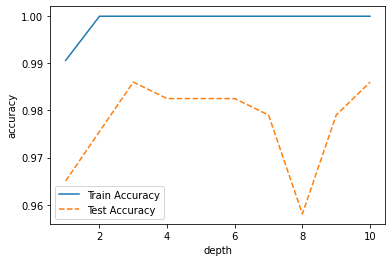

In [82]:
plt.plot(para_depth, train_accuracy, linestyle = '-', label = 'Train Accuracy')
plt.plot(para_depth, test_accuracy, linestyle = '--', label = 'Test Accuracy')
plt.ylabel('accuracy'); plt.xlabel('depth')
plt.legend()

In [83]:
# train, test 정확도 결과 저장용
train_accuracy = []; test_accuracy = []

# min_samples_split
para_split = [n_split*10 for n_split in range(2,11)]

for v_min_samples_split in para_split:
    gb = GradientBoostingClassifier(min_samples_split = v_min_samples_split, max_depth = 10, n_estimators = 70, 
                                    learning_rate = 0.4, random_state = 100)
    gb.fit(df_train_x, df_train_y)
    train_accuracy.append(gb.score(df_train_x, df_train_y))
    test_accuracy.append(gb.score(df_test_x, df_test_y))
    
#데이텉 테이블로 저장
df_accuracy_split = pd.DataFrame()
df_accuracy_split['MinSamplesSplit'] = para_split
df_accuracy_split['TrainAccuracy'] = train_accuracy
df_accuracy_split['TestAccuracy'] = test_accuracy

# 모델 정확도 확인
df_accuracy_split.round(3)

,MinSamplesSplit,TrainAccuracy,TestAccuracy
0,20,1.0,0.986
1,30,1.0,1.000
2,40,1.0,1.000
3,50,1.0,1.000
4,60,1.0,1.000
5,70,1.0,0.993
6,80,1.0,1.000
7,90,1.0,0.993
8,100,1.0,0.997


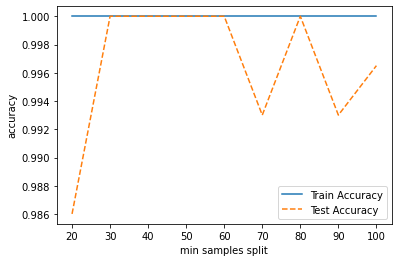

In [84]:
#모델로 정확도 확인
plt.plot(para_split, train_accuracy, linestyle = '-', label = 'Train Accuracy')
plt.plot(para_split, test_accuracy, linestyle = '--', label = 'Test Accuracy')
plt.ylabel('accuracy'); plt.xlabel('min samples split')
plt.legend()

In [85]:
# train, test 정확도 결과 저장용
train_accuracy = []; test_accuracy = []

# min_samples_split
para_leaf = [n_leaf for n_leaf in range(1,11)]

for v_min_samples_leaf in para_leaf:
    gb = GradientBoostingClassifier(min_samples_leaf = v_min_samples_leaf, max_depth = 10, n_estimators = 70, min_samples_split = 30,
                                    learning_rate = 0.4, random_state = 100)
    gb.fit(df_train_x, df_train_y)
    train_accuracy.append(gb.score(df_train_x, df_train_y))
    test_accuracy.append(gb.score(df_test_x, df_test_y))
    
#데이텉 테이블로 저장
df_accuracy_leaf = pd.DataFrame()
df_accuracy_leaf['MinSamplesLeaf'] = para_leaf
df_accuracy_leaf['TrainAccuracy'] = train_accuracy
df_accuracy_leaf['TestAccuracy'] = test_accuracy

df_accuracy_leaf.round(3)

,MinSamplesLeaf,TrainAccuracy,TestAccuracy
0,1,1.0,1.000
1,2,1.0,0.993
2,3,1.0,0.976
3,4,1.0,0.986
4,5,1.0,0.990
5,6,1.0,0.990
6,7,1.0,0.990
7,8,1.0,0.986
8,9,1.0,0.986
9,10,1.0,0.986


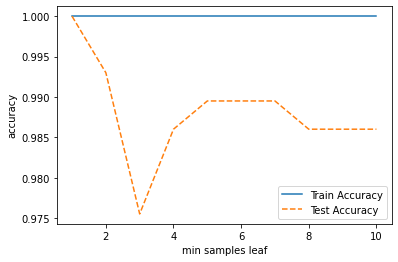

In [86]:
#모델로 정확도 확인
plt.plot(para_leaf, train_accuracy, linestyle = '-', label = 'Train Accuracy')
plt.plot(para_leaf, test_accuracy, linestyle = '--', label = 'Test Accuracy')
plt.ylabel('accuracy'); plt.xlabel('min samples leaf')
plt.legend()

In [87]:
gb_final = GradientBoostingClassifier(min_samples_leaf=7, max_depth=10, n_estimators=700, 
                                      min_samples_split = 30, learning_rate=0.4,random_state = 100)
gb_final.fit(df_train_x, df_train_y)
y_pred = gb_final.predict(df_test_x)
# train 데이터 셋 정확도
print("Accuracy on training set: {:.3f}".format(gb_final.score(df_train_x, df_train_y)))
# test 데이터 셋 정확도
print("Accuracy on test set: {:.3f}\n".format(gb_final.score(df_test_x, df_test_y)))

Accuracy on training set: 1.000
Accuracy on test set: 0.990



In [88]:
#confusion matrix
print("Confusion matrix:\n{}".format(confusion_matrix(df_test_y, y_pred)))
#목표변수의 빈도 불균형 : f1 score로 모델 평가
print(classification_report(df_test_y, y_pred, digits=3))

Confusion matrix:
[[186   0]
 [  3  97]]
              precision    recall  f1-score   support

           0      0.984     1.000     0.992       186
           1      1.000     0.970     0.985       100

    accuracy                          0.990       286
   macro avg      0.992     0.985     0.988       286
weighted avg      0.990     0.990     0.989       286



### Feature Importance

Text(0, 0.5, '설명변수')

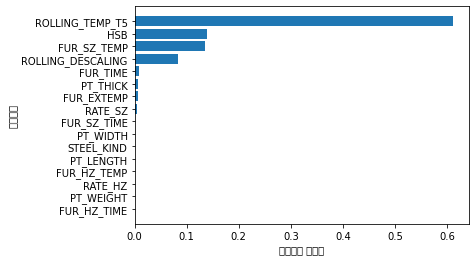

In [89]:
gb_importance = pd.DataFrame()

gb_importance['Feature'] = v_feature_name
gb_importance['Importance'] = gb_final.feature_importances_
gb_importance.sort_values('Importance', ascending = False, inplace = True)
gb_importance.round(3)

#설명변수 중요도 그래프
#중요도가 높은 변수를 상위에 그림
gb_importance.sort_values("Importance", ascending=True, inplace = True)
coordinates = range(len (gb_importance))
plt.barh(y = coordinates, width = gb_importance ["Importance"])
plt.yticks(coordinates, gb_importance ["Feature"])
plt.xlabel("설명변수 중요도")
plt.ylabel("설명변수")

## SVM

In [90]:
# SVM
from sklearn.svm import SVC

In [91]:
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df_raw_x)
df_scaled = pd.DataFrame(df_scaled, columns = v_feature_name)
df_scaled.head()

,STEEL_KIND,PT_THICK,PT_WIDTH,PT_LENGTH,PT_WEIGHT,FUR_HZ_TEMP,FUR_HZ_TIME,FUR_SZ_TEMP,FUR_SZ_TIME,FUR_TIME,FUR_EXTEMP,ROLLING_TEMP_T5,HSB,ROLLING_DESCALING,RATE_HZ,RATE_SZ
0,-0.205907,0.537573,0.588810,-1.279914,-1.043582,0.700686,-1.046094,-0.728704,0.367443,-0.823824,-0.935181,-0.924116,0.220294,-0.201215,1.515057,-0.670587
1,-0.205907,1.999436,0.610765,-1.740969,-1.017347,-0.740713,0.993903,-1.014526,-0.019666,1.254012,-0.935181,-1.486818,0.220294,-1.437995,-1.175352,-0.327746
2,-0.205907,2.393014,-0.157678,-1.787271,-1.036317,-1.557506,-0.237130,-1.357512,-0.578825,-0.204894,-1.328531,-2.764306,0.220294,-1.437995,-0.134249,0.350369
3,-0.205907,2.393014,-0.606768,-1.472014,0.016696,-1.413366,0.607007,-1.414676,-0.578825,-0.558568,-1.328531,-1.502027,0.220294,-1.437995,-0.945149,0.346853
4,-0.205907,2.393014,-0.606768,-1.469619,0.020732,-1.077040,0.290456,-1.414676,0.066358,0.082466,-1.159953,-1.258696,0.220294,-1.437995,-0.668237,-0.433840


In [92]:
# Data Split
random = 100
df_scaled_train_x, df_scaled_test_x, df_scaled_train_y, df_scaled_test_y = train_test_split(df_scaled, df_raw_y, test_size = 0.4, random_state = random)

In [93]:
estimator = SVC(random_state=random)
para_c = [c*0.1 for c in range(1,21)]
para_gamma = [0.05*gamma for gamma in range(1,15)]
param_gird = {"C" : para_c, "gamma" : para_gamma}

grid_svm = GridSearchCV(estimator, param_gird, scoring="accuracy", n_jobs = -1)
grid_svm.fit(df_scaled_train_x, df_scaled_train_y)
print("best estimator model: \n {0}".format(grid_svm.best_estimator_))
print("\n best parameter: \n {}".format(grid_svm.best_params_))
print("\n best score: \n {}".format(grid_svm.best_score_.round(3)))

best estimator model: 
 SVC(C=1.7000000000000002, gamma=0.05, random_state=100)

 best parameter: 
 {'C': 1.7000000000000002, 'gamma': 0.05}

 best score: 
 0.904


In [94]:
# train_acc = []
# test_acc = []

# para_c = [c*0.1 for c in range(1,21)]

# for v_C in para_c:
#     svm_c = SVC(random_state = random, C = v_C)
#     svm_c.fit(df_train_x, df_train_y)
#     train_acc.append(svm_c.score(df_train_x, df_train_y))
#     test_acc.append(svm_c.score(df_test_x, df_test_y))

# # 결과 저장
# df_acc_C = pd.DataFrame()
# df_acc_C["C"] = para_c
# df_acc_C["TrainScore"] = train_acc
# df_acc_C["TestScore"] = test_acc

# df_acc_C.round(3)

# # 그래프
# plt.plot(para_c, train_acc, linestyle = "-", label = "TrainAccuracy")
# plt.plot(para_c, test_acc, linestyle = "--", label = "TestAccuracy")
# plt.ylabel("ACC")
# plt.xlabel("C")
# plt.legend()

In [95]:
# train_acc = []
# test_acc = []

# para_gamma = [0.05*gamma for gamma in range(1,15)]

# for v_gamma in para_gamma:
#     svm_gamma = SVC(random_state = random, gamma = v_gamma)
#     svm_gamma.fit(df_train_x, df_train_y)
#     train_acc.append(svm_gamma.score(df_train_x, df_train_y))
#     test_acc.append(svm_gamma.score(df_test_x, df_test_y))

# # 결과 저장
# df_acc_gamma = pd.DataFrame()
# df_acc_gamma["C"] = para_gamma
# df_acc_gamma["TrainScore"] = train_acc
# df_acc_gamma["TestScore"] = test_acc

# df_acc_gamma.round(3)

# # 그래프
# plt.plot(para_gamma, train_acc, linestyle = "-", label = "TrainAccuracy")
# plt.plot(para_gamma, test_acc, linestyle = "--", label = "TestAccuracy")
# plt.ylabel("ACC")
# plt.xlabel("Gamma")
# plt.legend()

In [96]:
svc_final = SVC(gamma = 0.05, C = 1.7, random_state = random)
svc_final.fit(df_scaled_train_x, df_train_y)
y_pred = svc_final.predict(df_scaled_test_x)
# ACC
print("Accuracy on train set : {:.3f}".format(svc_final.score(df_scaled_train_x, df_train_y)))
print("Accuracy on test set : {:.3f}".format(svc_final.score(df_scaled_test_x, df_test_y)))

Accuracy on train set : 0.934
Accuracy on test set : 0.906


In [97]:
# confusion matrix
print("Confusion matrix : \n{}".format(confusion_matrix(df_test_y, y_pred)))
# 목표변수의 빈도 불균형 : f1 score
print(classification_report(df_test_y, y_pred, digits=3))

Confusion matrix : 
[[180   6]
 [ 21  79]]
              precision    recall  f1-score   support

           0      0.896     0.968     0.930       186
           1      0.929     0.790     0.854       100

    accuracy                          0.906       286
   macro avg      0.912     0.879     0.892       286
weighted avg      0.907     0.906     0.904       286



## KNN

In [98]:
# KNN
from sklearn.neighbors import KNeighborsClassifier

In [99]:
train_acc = []
test_acc = []
# 0.01 ~ 100
para_n = [n for n in range(3,30)]

for v_para_n in para_n:
    knn_c = KNeighborsClassifier(n_neighbors = v_para_n)
    knn_c.fit(df_scaled_train_x, df_train_y)
    train_acc.append(knn_c.score(df_scaled_train_x, df_train_y))
    test_acc.append(knn_c.score(df_scaled_test_x, df_test_y))

# 결과 저장
df_acc_n = pd.DataFrame()
df_acc_n["Neighbors"] = para_n
df_acc_n["TrainScore"] = train_acc
df_acc_n["TestScore"] = test_acc

df_acc_n.round(3)

,Neighbors,TrainScore,TestScore
0,3,0.932,0.885
1,4,0.913,0.878
2,5,0.909,0.888
3,6,0.909,0.888
4,7,0.906,0.885
5,8,0.899,0.874
6,9,0.902,0.874
7,10,0.895,0.878
8,11,0.883,0.888
9,12,0.883,0.874


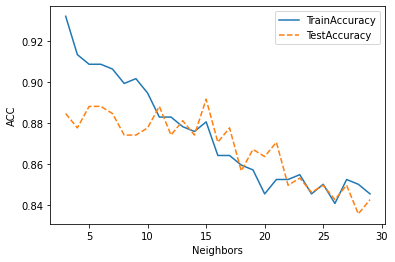

In [100]:
# 그래프
plt.plot(para_n, train_acc, linestyle = "-", label = "TrainAccuracy")
plt.plot(para_n, test_acc, linestyle = "--", label = "TestAccuracy")
plt.ylabel("ACC")
plt.xlabel("Neighbors")
plt.legend()

In [101]:
train_acc = []
test_acc = []

para_n = [n for n in range(1,31)]*2
para_w = (["uniform"]*30 + (["distance"]*30))

for [v_para_n, v_para_w] in zip(para_n, para_w):
    knn_w = KNeighborsClassifier(n_neighbors = v_para_n, weights = v_para_w)
    knn_w.fit(df_train_x, df_train_y)
    train_acc.append(knn_w.score(df_train_x, df_train_y))
    test_acc.append(knn_w.score(df_test_x, df_test_y))

# 결과 저장
df_acc_w = pd.DataFrame()
df_acc_w["Neighbors"] = para_n
df_acc_w["Weights"] = para_w
df_acc_w["TrainScore"] = train_acc
df_acc_w["TestScore"] = test_acc

df_acc_w.round(3)

,Neighbors,Weights,TrainScore,TestScore
0,1,uniform,1.000,0.713
1,2,uniform,0.867,0.699
2,3,uniform,0.841,0.699
3,4,uniform,0.801,0.713
4,5,uniform,0.813,0.720
5,6,uniform,0.775,0.692
6,7,uniform,0.796,0.706
7,8,uniform,0.766,0.720
8,9,uniform,0.768,0.710
9,10,uniform,0.740,0.710


<AxesSubplot:xlabel='Neighbors'>

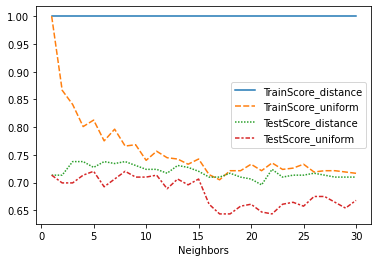

In [102]:
# Data Pivot
df_acc_w_pivot = df_acc_w.pivot(index="Neighbors", columns='Weights', values = ["TrainScore","TestScore"])
df_acc_w_pivot
# 그래프 
level0 = df_acc_w_pivot.columns.get_level_values(0)
level1 = df_acc_w_pivot.columns.get_level_values(1)
df_acc_w_pivot.columns = level0 + "_" + level1
df_acc_w_pivot.head()
sns.lineplot(data = df_acc_w_pivot)

In [103]:
train_acc = []
test_acc = []

para_n = [n for n in range(1,31)] * 2
para_metric = (["euclidean"]*30 + (["manhattan"]*30))

for [v_para_n, v_metric] in zip(para_n, para_metric):
    knn_w = KNeighborsClassifier(n_neighbors = v_para_n, metric = v_metric, weights = "uniform")
    knn_w.fit(df_train_x, df_train_y)
    train_acc.append(knn_w.score(df_train_x, df_train_y))
    test_acc.append(knn_w.score(df_test_x, df_test_y))

# 결과 저장
df_acc_m = pd.DataFrame()
df_acc_m["Neighbors"] = para_n
df_acc_m["Metric"] = para_metric
df_acc_m["TrainScore"] = train_acc
df_acc_m["TestScore"] = test_acc

df_acc_m.round(3)

,Neighbors,Metric,TrainScore,TestScore
0,1,euclidean,1.000,0.713
1,2,euclidean,0.867,0.699
2,3,euclidean,0.841,0.699
3,4,euclidean,0.801,0.713
4,5,euclidean,0.813,0.720
5,6,euclidean,0.775,0.692
6,7,euclidean,0.796,0.706
7,8,euclidean,0.766,0.720
8,9,euclidean,0.768,0.710
9,10,euclidean,0.740,0.710


<AxesSubplot:xlabel='Neighbors'>

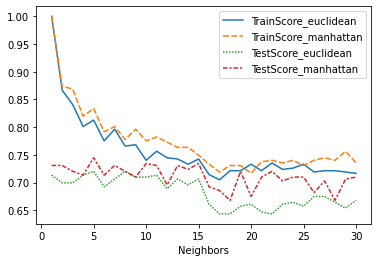

In [104]:
# Data Pivot
df_acc_m_pivot = df_acc_m.pivot(index="Neighbors", columns="Metric", values = ["TrainScore","TestScore"])
level0 = df_acc_m_pivot.columns.get_level_values(0)
level1 = df_acc_m_pivot.columns.get_level_values(1)
df_acc_m_pivot.columns = level0 + "_" + level1
df_acc_m_pivot.head()
sns.lineplot(data = df_acc_m_pivot)

In [105]:
knn_final = KNeighborsClassifier(n_neighbors = 10, metric = "euclidean", weights = "distance")
knn_final.fit(df_scaled_train_x, df_train_y)
y_pred = knn_final.predict(df_scaled_test_x)
# ACC
print("Accuracy on train set : {:.3f}".format(knn_final.score(df_scaled_train_x, df_train_y)))
print("Accuracy on test set : {:.3f}".format(knn_final.score(df_scaled_test_x, df_test_y)))
# confusion matrix
print("Confusion matrix : \n{}".format(confusion_matrix(df_scaled_test_y, y_pred)))
# 목표변수의 빈도 불균형 : f1 score
print(classification_report(df_test_y, y_pred, digits=3))

Accuracy on train set : 1.000
Accuracy on test set : 0.881
Confusion matrix : 
[[178   8]
 [ 26  74]]
              precision    recall  f1-score   support

           0      0.873     0.957     0.913       186
           1      0.902     0.740     0.813       100

    accuracy                          0.881       286
   macro avg      0.887     0.848     0.863       286
weighted avg      0.883     0.881     0.878       286



## NN

In [106]:
# NN
from sklearn.neural_network import MLPClassifier

In [107]:
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df_raw_x)
df_scaled = pd.DataFrame(df_scaled, columns=v_feature_name)
df_scaled.head()

df_scaled_train_x, df_scaled_test_x = train_test_split(df_scaled, test_size=0.4, random_state=random)
print('train data X size:{}'.format(df_scaled_train_x.shape))
print('test data X size:{}'.format(df_scaled_test_x.shape))

train data X size:(427, 16)
test data X size:(286, 16)


In [108]:
train_accuracy = []
test_accuracy = []
# para_hidden = [5 * hidden for hidden in range(1, 21)]
para_hidden = [hidden for hidden in range(20, 50)]
print(para_hidden)

for v_hidden in para_hidden:
    nn = MLPClassifier(hidden_layer_sizes=(v_hidden, v_hidden),random_state=random)
    nn.fit(df_scaled_train_x, df_train_y)
    train_accuracy.append(nn.score(df_scaled_train_x, df_train_y))
    test_accuracy.append(nn.score(df_scaled_test_x, df_test_y))
    
df_accuracy_hidden = pd.DataFrame()
df_accuracy_hidden['HiddenLayer'] = para_hidden
df_accuracy_hidden['TrainAccuracy'] = train_accuracy
df_accuracy_hidden['TestAccuracy'] = test_accuracy

df_accuracy_hidden.round(3)

[20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49]


,HiddenLayer,TrainAccuracy,TestAccuracy
0,20,0.927,0.902
1,21,0.944,0.916
2,22,0.937,0.892
3,23,0.939,0.906
4,24,0.939,0.899
5,25,0.941,0.888
6,26,0.937,0.916
7,27,0.930,0.892
8,28,0.946,0.899
9,29,0.951,0.902


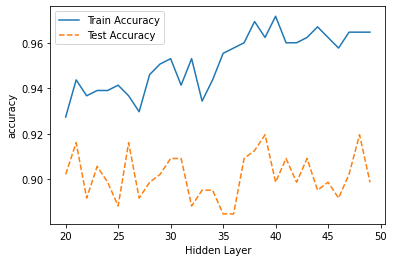

In [109]:
plt.plot(para_hidden, train_accuracy, linestyle='-', label='Train Accuracy')
plt.plot(para_hidden, test_accuracy, linestyle='--', label='Test Accuracy')
plt.ylabel('accuracy')
plt.xlabel('Hidden Layer')
plt.legend()
plt.show()

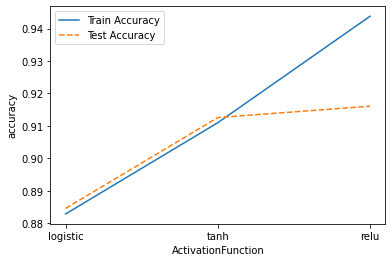

In [110]:
train_accuracy = []
test_accuracy = []
para_function = ['logistic', 'tanh', 'relu']

for v_function in para_function:
    nn = MLPClassifier(activation=v_function, hidden_layer_sizes=(21, 21),random_state=random)
    nn.fit(df_scaled_train_x, df_train_y)
    train_accuracy.append(nn.score(df_scaled_train_x, df_train_y))
    test_accuracy.append(nn.score(df_scaled_test_x, df_test_y))
    
df_accuracy_function = pd.DataFrame()
df_accuracy_function['ActivationFunction'] = para_function
df_accuracy_function['TrainAccuracy'] = train_accuracy
df_accuracy_function['TestAccuracy'] = test_accuracy

df_accuracy_function.round(3)

plt.plot(para_function, train_accuracy, linestyle='-', label='Train Accuracy')
plt.plot(para_function, test_accuracy, linestyle='--', label='Test Accuracy')
plt.ylabel('accuracy')
plt.xlabel('ActivationFunction')
plt.legend()
plt.show()

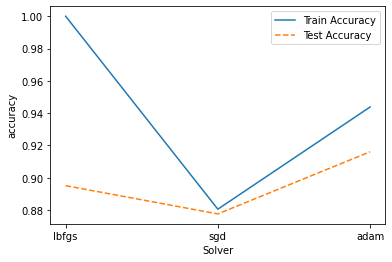

In [111]:
train_accuracy = []
test_accuracy = []
para_solver = ['lbfgs', 'sgd', 'adam']

for v_solver in para_solver:
    nn = MLPClassifier(solver=v_solver, activation='relu', hidden_layer_sizes=(21, 21),random_state=random)
    nn.fit(df_scaled_train_x, df_train_y)
    train_accuracy.append(nn.score(df_scaled_train_x, df_train_y))
    test_accuracy.append(nn.score(df_scaled_test_x, df_test_y))
    
df_accuracy_solver = pd.DataFrame()
df_accuracy_solver['Solver'] = para_solver
df_accuracy_solver['TrainAccuracy'] = train_accuracy
df_accuracy_solver['TestAccuracy'] = test_accuracy

df_accuracy_solver.round(3)

plt.plot(para_solver, train_accuracy, linestyle='-', label='Train Accuracy')
plt.plot(para_solver, test_accuracy, linestyle='--', label='Test Accuracy')
plt.ylabel('accuracy')
plt.xlabel('Solver')
plt.legend()
plt.show()

[20, 40, 60, 80, 100, 120, 140, 160, 180]


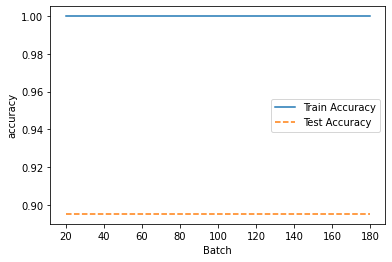

In [112]:
train_accuracy = []
test_accuracy = []
para_batch = [20 * batch for batch in range(1, 10)]

print(para_batch)

for v_batch in para_batch:
    nn = MLPClassifier(batch_size=v_batch, solver='lbfgs', activation='relu', hidden_layer_sizes=(21, 21), random_state=random)
    nn.fit(df_scaled_train_x, df_train_y)
    train_accuracy.append(nn.score(df_scaled_train_x, df_train_y))
    test_accuracy.append(nn.score(df_scaled_test_x, df_test_y))
    
df_accuracy_batch = pd.DataFrame()
df_accuracy_batch['Mini Batch'] = para_batch
df_accuracy_batch['TrainAccuracy'] = train_accuracy
df_accuracy_batch['TestAccuracy'] = test_accuracy

df_accuracy_batch.round(3)

plt.plot(para_batch, train_accuracy, linestyle='-', label='Train Accuracy')
plt.plot(para_batch, test_accuracy, linestyle='--', label='Test Accuracy')
plt.ylabel('accuracy')
plt.xlabel('Batch')
plt.legend()
plt.show()

In [113]:
random

100

In [114]:
nn_final = MLPClassifier(batch_size=50, solver='lbfgs', activation='relu', hidden_layer_sizes=(21, 21), random_state=random)
nn_final.fit(df_scaled_train_x, df_train_y)
y_pred = nn_final.predict(df_scaled_test_x)

print('Accuracy on training set: {:.3f}'.format(nn_final.score(df_scaled_train_x, df_train_y)))
print('Accuracy on test set: {:.3f}'.format(nn_final.score(df_scaled_test_x, df_test_y)))
print('Confusion matrix:\n{}'.format(confusion_matrix(df_test_y, y_pred)))
print(classification_report(df_test_y, y_pred, digits=3))

Accuracy on training set: 1.000
Accuracy on test set: 0.895
Confusion matrix:
[[174  12]
 [ 18  82]]
              precision    recall  f1-score   support

           0      0.906     0.935     0.921       186
           1      0.872     0.820     0.845       100

    accuracy                          0.895       286
   macro avg      0.889     0.878     0.883       286
weighted avg      0.894     0.895     0.894       286



# 시뮬레이션

In [373]:
df_raw = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/SCALE불량.csv', encoding = 'euc-kr')

In [374]:
df_raw['FUR_NO_ROW'] = df_raw['FUR_NO_ROW'].astype('object')
df_raw['WORK_GR'] = df_raw['WORK_GR'].astype('object')
df_raw['HSB'] = df_raw['HSB'].astype('object')
df_raw['HSB'] = np.where(df_raw['HSB'] == '적용', 1, 0) # 적용:1 미적용:0으로 변환
df_raw['SCALE'] = np.where(df_raw['SCALE'] == '양품', 0, 1) # 불량:1 양품:0으로 변환
df_raw['SCALE'] = df_raw['SCALE'].astype('object')

<AxesSubplot:>

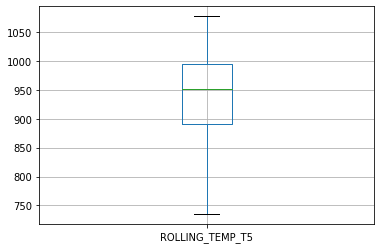

In [375]:
df_raw.sort_values(by='ROLLING_TEMP_T5', ascending=False).tail(6)
df_raw.drop(df_raw[df_raw['ROLLING_TEMP_T5'] == 0].index, inplace=True)
# FUR_HZ_TIME
IQR = df_raw['ROLLING_TEMP_T5'].quantile(0.75) - df_raw['ROLLING_TEMP_T5'].quantile(0.25)
line_down = df_raw['ROLLING_TEMP_T5'].quantile(0.25) - IQR*1.5
line_up = df_raw['ROLLING_TEMP_T5'].quantile(0.75) + IQR*1.5

winsoried = df_raw['ROLLING_TEMP_T5'].clip(line_down, line_up)
df_raw['ROLLING_TEMP_T5'] = winsoried 
df_raw[['ROLLING_TEMP_T5']].boxplot()

In [376]:
df_raw["SCALE"] = pd.to_numeric(df_raw["SCALE"], errors = 'coerce')
df_raw = df_raw.astype({'PT_THICK' : 'int'})

## 조건 1 : 가열대 온도, 균열대 온도, 압연 온도 최적 조건 도출

In [377]:
# Data Split
con1 = ["SCALE", "FUR_HZ_TEMP", "FUR_SZ_TEMP", "ROLLING_TEMP_T5"]
con2 = ["SCALE", "FUR_HZ_TEMP", "FUR_SZ_TEMP", "FUR_EXTEMP", "ROLLING_TEMP_T5", "HSB"]
df_raw_simul = df_raw.drop(["PLATE_NO","ROLLING_DATE","SPEC","STEEL_KIND","FUR_NO","FUR_NO_ROW","WORK_GR"], errors='ignore', axis= 1, inplace = False)
df_raw_x = df_raw_simul[con1]
df_raw_x = df_raw_x.drop("SCALE", axis = 1, inplace = False)
df_raw_y = df_raw["SCALE"]
print(len(list(df_raw_y)))
print(list(df_raw_y).count(1))
df_train_x, df_test_x, df_train_y, df_test_y = train_test_split(df_raw_x, df_raw_y, test_size = 0.3)

714
231


Accuracy: 0.907

Confusion matrix: 
[[143   0]
 [ 20  52]]
              precision    recall  f1-score   support

           0      0.877     1.000     0.935       143
           1      1.000     0.722     0.839        72

    accuracy                          0.907       215
   macro avg      0.939     0.861     0.887       215
weighted avg      0.918     0.907     0.903       215



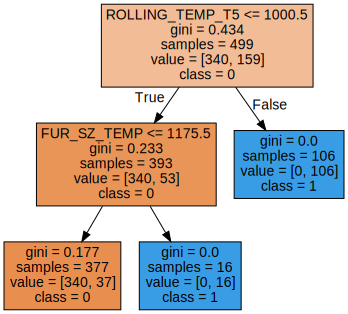

In [380]:
tree_final = DecisionTreeClassifier(min_samples_leaf = 8, min_samples_split = 20, max_depth = 2)
tree_final.fit(df_train_x, df_train_y)
y_pred = tree_final.predict(df_test_x)
print("Accuracy: {0:.3f}\n".format(tree_final.score(df_test_x,df_test_y)))
print("Confusion matrix: \n{0}".format(confusion_matrix(df_test_y, y_pred)))
print(classification_report(df_test_y, y_pred, digits=3))

## Visualizing Tree using Graphviz
con1 = con1[1:]
from sklearn import tree
import graphviz

## exporting tree in DOT format
## refer to: https://scikit-learn.org/stable/modules/generated/sklearn.tree.export_graphviz.html
tree_dot = tree.export_graphviz(
    tree_final, 
    feature_names=con1, 
    class_names=['0', '1'],
    filled=True
)


## draw graph using Graphviz
dt_graph = graphviz.Source(tree_dot, format='png')
dt_graph

* 압연온도 1000.5도 이상에서 불량증가
* 균열대 온도 1175.5도 이상에서 불량증가

## 조건 2 : 가열대 온도, 균열대 온도, 가열로 온도, 압연온도, HSB 처리 유무

In [383]:
# Data Split
con1 = ["SCALE", "FUR_HZ_TEMP", "FUR_SZ_TEMP", "ROLLING_TEMP_T5"]
con2 = ["SCALE", "FUR_HZ_TEMP", "FUR_SZ_TEMP", "FUR_EXTEMP", "ROLLING_TEMP_T5", "HSB"]
df_raw_simul = df_raw.drop(["PLATE_NO","ROLLING_DATE","SPEC","STEEL_KIND","FUR_NO","FUR_NO_ROW","WORK_GR"], errors='ignore', axis= 1, inplace = False)
df_raw_x = df_raw_simul[con2]
df_raw_x = df_raw_x.drop("SCALE", axis = 1, inplace = False)
df_raw_y = df_raw["SCALE"]
print(len(list(df_raw_y)))
print(list(df_raw_y).count(1))
df_train_x, df_test_x, df_train_y, df_test_y = train_test_split(df_raw_x, df_raw_y, test_size = 0.3)

714
231


Accuracy: 0.944

Confusion matrix: 
[[136   0]
 [ 12  67]]
              precision    recall  f1-score   support

           0      0.919     1.000     0.958       136
           1      1.000     0.848     0.918        79

    accuracy                          0.944       215
   macro avg      0.959     0.924     0.938       215
weighted avg      0.949     0.944     0.943       215



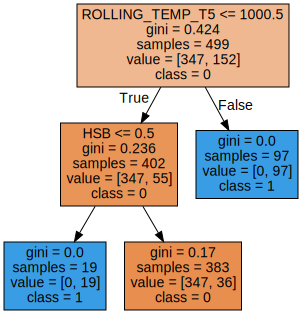

In [385]:
tree_final = DecisionTreeClassifier(min_samples_leaf = 8, min_samples_split = 20, max_depth = 2)
tree_final.fit(df_train_x, df_train_y)
y_pred = tree_final.predict(df_test_x)
print("Accuracy: {0:.3f}\n".format(tree_final.score(df_test_x,df_test_y)))
print("Confusion matrix: \n{0}".format(confusion_matrix(df_test_y, y_pred)))
print(classification_report(df_test_y, y_pred, digits=3))

## Visualizing Tree using Graphviz
con = con2[1:]
from sklearn import tree
import graphviz

## exporting tree in DOT format
## refer to: https://scikit-learn.org/stable/modules/generated/sklearn.tree.export_graphviz.html
tree_dot = tree.export_graphviz(
    tree_final, 
    feature_names=con, 
    class_names=['0', '1'],
    filled=True
)


## draw graph using Graphviz
dt_graph = graphviz.Source(tree_dot, format='png')
dt_graph

* 압연온도 1000.5도 이상에서 불량 증가
* 압연온도 1000.5도 이하에서, HSB를 실시 하지 않는 경우 불량 증가

## 시뮬레이션 진행

In [392]:
import random
FUR_SZ_TEMP_sim = random.choices(range(1113,1175), k = 714)
# ROLLING_TEMP_T5_sim = random.choices(range(735,1001), k = 714)
HSB_sim = [1] * 714

In [393]:
df_raw["SCALE"] = pd.to_numeric(df_raw["SCALE"], errors = 'coerce')
df_raw = df_raw.astype({'PT_THICK' : 'int'})

In [394]:
df_raw_sim = df_raw.drop(["PLATE_NO","ROLLING_DATE","SPEC","STEEL_KIND","FUR_NO","FUR_NO_ROW","WORK_GR"], errors='ignore', axis= 1, inplace = False)
df_train_x_sim = df_raw_sim.drop("SCALE", axis= 1, inplace = False)
df_train_y_sim = df_raw_sim["SCALE"]
tree_final = DecisionTreeClassifier(min_samples_leaf = 8, min_samples_split = 20, max_depth = 2)
tree_final.fit(df_train_x_sim, df_train_y_sim)
print('Score on training set: {:.3f}'.format(tree_final.score(df_train_x_sim, df_train_y_sim)))

Score on training set: 0.933


In [395]:
df_test_sim = df_raw_sim
df_test_sim["FUR_SZ_TEMP"] = FUR_SZ_TEMP_sim
# df_test_sim["ROLLING_TEMP_T5"] = ROLLING_TEMP_T5_sim
df_test_sim["HSB"] = HSB_sim
df_test_x_sim = df_test_sim.drop("SCALE", axis= 1, inplace = False)
y_pred_sim = tree_final.predict(df_test_x_sim)

In [396]:
list(y_pred_sim).count(1)

152

* 균열도 최적조건, HSB 처리를 실시할 경우, 불량률이 32%에서 21%까지 감소한다.
* 압연온도의 최적조건만 달성하더라도 불량률이 0%가 되는 것을 확인하였다.
